Best parameters for Decision Tree: {'max_depth': 5, 'max_features': 17}
Best parameters for Random Forest: {'max_depth': 15, 'max_features': 'log2', 'n_estimators': 200}

Evaluation metrics for Decision Tree:
Confusion Matrix:
[[82 16]
 [ 3 94]]
Precision:
0.8545454545454545
Recall:
0.9690721649484536
Accuracy:
0.9025641025641026
F1 Score:
0.9082125603864734
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.84      0.90        98
           1       0.85      0.97      0.91        97

    accuracy                           0.90       195
   macro avg       0.91      0.90      0.90       195
weighted avg       0.91      0.90      0.90       195


Evaluation metrics for K-Nearest Neighbors:
Confusion Matrix:
[[83 15]
 [ 6 91]]
Precision:
0.8584905660377359
Recall:
0.9381443298969072
Accuracy:
0.8923076923076924
F1 Score:
0.896551724137931
Classification Report:
              precision    recall  f1-score   support

           0   

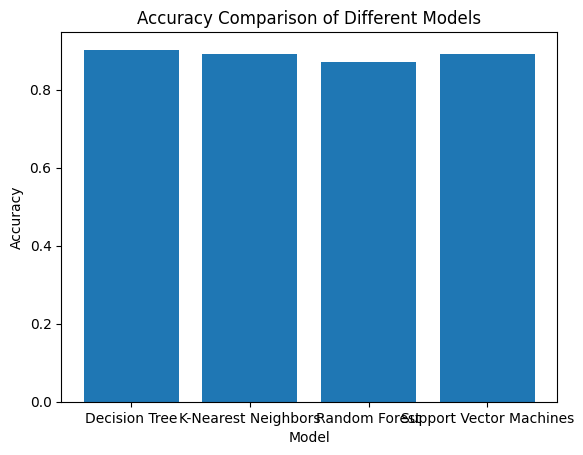

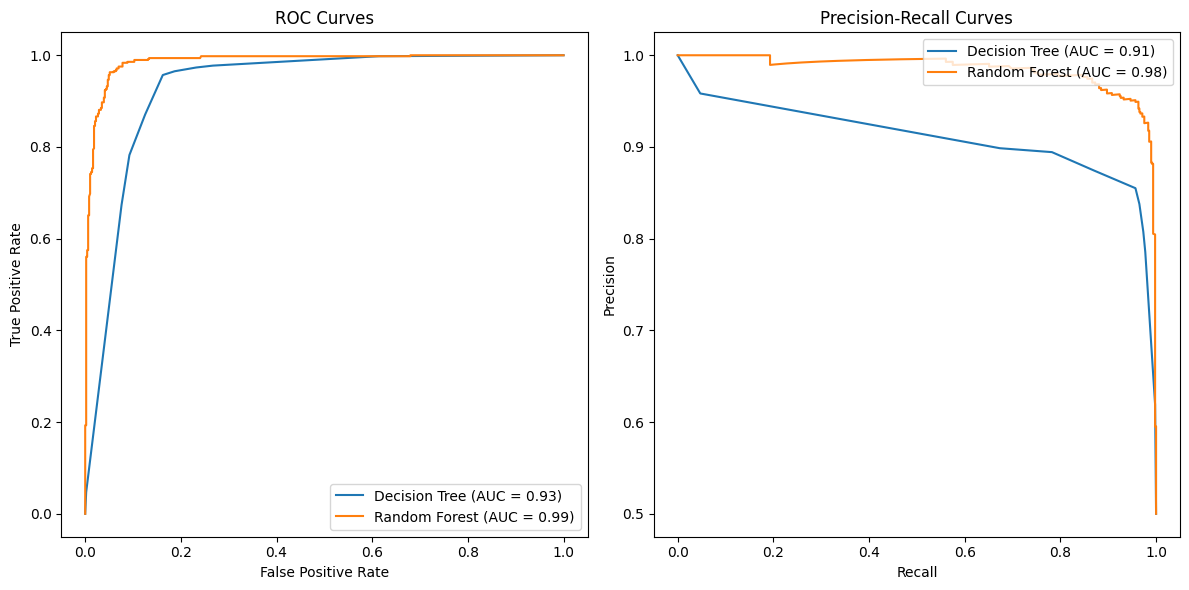


Hyperparameter tuning results for Decision Tree:
                                    params  mean_test_score  std_test_score
0   {'max_depth': None, 'max_features': 1}         0.860407        0.020935
1   {'max_depth': None, 'max_features': 2}         0.865546        0.027260
2   {'max_depth': None, 'max_features': 3}         0.864494        0.018117
3   {'max_depth': None, 'max_features': 4}         0.864520        0.029871
4   {'max_depth': None, 'max_features': 5}         0.865535        0.040609
..                                     ...              ...             ...
87   {'max_depth': 15, 'max_features': 19}         0.861417        0.022361
88   {'max_depth': 15, 'max_features': 20}         0.867592        0.027085
89   {'max_depth': 15, 'max_features': 21}         0.856294        0.032808
90   {'max_depth': 15, 'max_features': 22}         0.865519        0.032275
91   {'max_depth': 15, 'max_features': 23}         0.854237        0.031938

[92 rows x 3 columns]

Hyperparameter

ValueError: cannot reshape array of size 24 into shape (4,2)

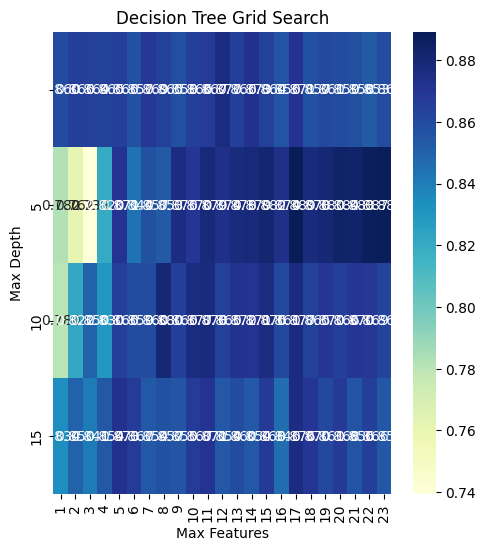

In [82]:
from sklearn.metrics import (
    confusion_matrix, precision_score, recall_score, f1_score,
    roc_curve, precision_recall_curve, accuracy_score, auc, classification_report
)
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
)
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import seaborn as sb

# Define the models to evaluate
models = {
    'Decision Tree': DecisionTreeClassifier(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machines': SVC(probability=True)
}

# Define evaluation metrics
metrics = {
    'Confusion Matrix': confusion_matrix,
    'Precision': precision_score,
    'Recall': recall_score,
    'Accuracy': accuracy_score,
    'F1 Score': f1_score,
    'Classification Report': classification_report
}

# Define hyperparameter grids for grid search
model_params = {
    'Decision Tree': {'max_depth': [None, 5, 10, 15], 'max_features': range(1, 24)},
    'Random Forest': {'n_estimators': [50, 100, 200], 'max_depth': [None, 5, 10, 15], 'max_features': ['sqrt', 'log2']}
}

# Perform model evaluation and comparison
model_scores = {}
model_times = {}
model_accuracies = {}
grid_searches = {}

mutation_data_clean = pd.read_csv('data/mutation_data_clean.csv')

# Extract the data and labels
all_inputs = mutation_data_clean[['Gender', 'Age_at_diagnosis', 'Race', 'IDH1', 'TP53', 'ATRX', 'PTEN', 'EGFR', 'CIC',
                                 'MUC16', 'PIK3CA', 'NF1', 'PIK3R1', 'FUBP1', 'RB1', 'NOTCH1', 'BCOR', 'CSMD3', 'SMARCA4',
                                 'GRIN2A', 'IDH2', 'FAT4', 'PDGFRA']].values
all_labels = mutation_data_clean['Grade'].values

# Apply feature scaling
scaler = StandardScaler()
all_inputs_scaled = scaler.fit_transform(all_inputs)

repetitions = 10

for model_name, model in models.items():
    scores = {}
    start_time = time.time()

    # Hyperparameter tuning using GridSearchCV
    if model_name in model_params:
        param_grid = model_params[model_name]
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=5, scoring='accuracy')
        grid_search.fit(all_inputs_scaled, all_labels)
        model = grid_search.best_estimator_
        print(f'Best parameters for {model_name}: {grid_search.best_params_}')
        grid_searches[model_name] = grid_search

    # Perform evaluation using cross-validation
    cv_scores = cross_val_score(model, all_inputs_scaled, all_labels, cv=StratifiedKFold(n_splits=10, shuffle=True))
    scores['Cross-Validation Mean'] = np.mean(cv_scores)
    scores['Cross-Validation STD'] = np.std(cv_scores)

    total_predictions = []
    for _ in range(repetitions):
        total_predictions = []  # Reset the list for each repetition

        # Split the data into training and testing sets
        training_inputs, testing_inputs, training_labels, testing_labels = train_test_split(all_inputs_scaled,
                                                                                            all_labels,
                                                                                            test_size=0.2,
                                                                                            stratify=all_labels)

        # Train the model
        model.fit(training_inputs, training_labels)

        # Predict on the testing set
        predictions = model.predict(testing_inputs)
        total_predictions.append(predictions)

    total_predictions = np.array(total_predictions)
    predictions_mean = np.mean(total_predictions, axis=0)
    
    scores['Accuracy'] = accuracy_score(testing_labels, predictions_mean.round().astype(int))
    scores['Precision'] = precision_score(testing_labels, predictions_mean.round().astype(int))
    scores['Recall'] = recall_score(testing_labels, predictions_mean.round().astype(int))
    scores['F1 Score'] = f1_score(testing_labels, predictions_mean.round().astype(int))
    scores['Confusion Matrix'] = confusion_matrix(testing_labels, predictions_mean.round().astype(int))
    scores['Classification Report'] = classification_report(testing_labels, predictions_mean.round().astype(int))
    
    model_scores[model_name] = scores
    model_times[model_name] = time.time() - start_time
    model_accuracies[model_name] = accuracy_score(testing_labels, predictions_mean.round().astype(int))

# Print the evaluation metrics for each model
for model_name, scores in model_scores.items():
    print(f'\nEvaluation metrics for {model_name}:')
    for metric_name, metric_func in metrics.items():
        if metric_name in scores:
            print(f'{metric_name}:')
            print(scores[metric_name])

# Compare the models based on accuracy
plt.bar(model_accuracies.keys(), model_accuracies.values())
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Accuracy Comparison of Different Models')
plt.show()

# ROC curves and Precision-Recall curves
plt.figure(figsize=(12, 6))
for model_name, grid_search in grid_searches.items():
    model = grid_search.best_estimator_
    if hasattr(model, 'predict_proba'):
        y_score = model.predict_proba(all_inputs_scaled)[:, 1]
    else:
        y_score = model.decision_function(all_inputs_scaled)
    fpr, tpr, thresholds = roc_curve(all_labels, y_score)
    precision, recall, _ = precision_recall_curve(all_labels, y_score)
    roc_auc = auc(fpr, tpr)
    pr_auc = auc(recall, precision)

    plt.subplot(1, 2, 1)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# Hyperparameter tuning results
for model_name, grid_search in grid_searches.items():
    print(f'\nHyperparameter tuning results for {model_name}:')
    cv_results = pd.DataFrame(grid_search.cv_results_)
    print(cv_results[['params', 'mean_test_score', 'std_test_score']])

# Grid search heatmap visualization
plt.figure(figsize=(12, 6))
for i, (model_name, grid_search) in enumerate(grid_searches.items()):
    param_grid = model_params[model_name]
    cv_results = pd.DataFrame(grid_search.cv_results_)  # Move this line inside the loop
    scores = np.array(cv_results['mean_test_score']).reshape(len(param_grid['max_depth']),
                                                            len(param_grid['max_features']))
    plt.subplot(1, len(grid_searches), i + 1)
    sb.heatmap(scores, annot=True, fmt='.3f', xticklabels=param_grid['max_features'],
               yticklabels=param_grid['max_depth'], cmap='YlGnBu')
    plt.xlabel('Max Features')
    plt.ylabel('Max Depth')
    plt.title(f'{model_name} Grid Search')
plt.tight_layout()
plt.show()
